# Re Implement attention mechanism with LSTM


data from files

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd

training_data = pd.read_csv("train_7.csv")
print (f"Training Data: {len(training_data)} example")
training_data.head()

test_data = pd.read_csv("test_7.csv")
print (f"Test Data: {len(test_data)} example")
test_data.head()

# extract text and labels
X_train = training_data['text']
y_train = training_data['label']
X_test = test_data['text']
y_test = test_data['label']

Training Data: 1600 example
Test Data: 400 example


lstm model

In [ ]:
import torch
from torch import nn
class SentimentAnalysisModelLSTM(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
        super(SentimentAnalysisModelLSTM, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        #batch first only true for RNNs
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)

        #no generation - take all the vectors (no decoder - no dynamic input)
        self.attention = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)

        # last layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded) # outputs [batchsize, sequence_length, hidden_size]

        # Attention mechanism
        attention_scores = self.attention(lstm_out) # outputs [batchsize, sequence_length, 1]

        attention_scores = attention_scores.squeeze(2) # outputs [batchsize, sequence_length]
        #scale scores to make them comparable
        attention_weights = self.softmax(attention_scores) # outputs [batchsize, sequence_length]

        context_vector = torch.sum(attention_weights.unsqueeze(2) * lstm_out, dim=1)

        output = self.fc(context_vector)
        return attention_weights, self.sigmoid(output)

processing data & dataloaders

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Tokenize the text and convert to one-hot vectors
word_to_idx = {}
idx = 0
X_train_onehot = []
X_test_onehot = []

# Tokenization and one-hot encoding
for sentence in X_train:
    sentence_onehot = [word_to_idx[word] if word in word_to_idx else (word_to_idx.setdefault(word, idx), idx := idx + 1)[1] for word in sentence.split()]
    X_train_onehot.append(sentence_onehot)

for sentence in X_test:
    sentence_onehot = [word_to_idx[word] if word in word_to_idx else (word_to_idx.setdefault(word, idx), idx := idx + 1)[1] for word in sentence.split()]
    X_test_onehot.append(sentence_onehot)

# Convert lists of one-hot indices to PyTorch tensors
X_train_onehot = [torch.tensor(sentence, dtype=torch.long) for sentence in X_train_onehot]
X_test_onehot = [torch.tensor(sentence, dtype=torch.long) for sentence in X_test_onehot]

# Pad sequences to have the same length (if necessary)
max_train_seq_length = max(len(sentence) for sentence in X_train_onehot)
max_test_seq_length = max(len(sentence) for sentence in X_test_onehot)
max_seq_length = max(max_train_seq_length, max_test_seq_length)

print (max_seq_length)
# Function to pad or truncate sequences to the specified length
def pad_or_truncate(sequence, length):
    if len(sequence) < length:
        return torch.cat([sequence, torch.zeros(length - len(sequence), dtype=torch.long)])
    else:
        return sequence[:length]

# Pad or truncate sequences in both training and test data
X_train_onehot = [pad_or_truncate(sentence, max_seq_length) for sentence in X_train_onehot]
X_test_onehot = [pad_or_truncate(sentence, max_seq_length) for sentence in X_test_onehot]

# Stack the sequences into a tensor
X_train_onehot = torch.stack(X_train_onehot)
X_test_onehot = torch.stack(X_test_onehot)

# Convert labels to PyTorch tensors
y_train = torch.tensor(training_data['label'].astype(float).values, dtype=torch.float32)
y_test = torch.tensor(test_data['label'].astype(float).values, dtype=torch.float32)

# Create DataLoader for training and testing
batch_size = 64
train_dataset = TensorDataset(X_train_onehot, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_onehot, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

input_size = len(word_to_idx) + 2 # to be on the safer side

2678


trainer

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
def train_model(model, train_data_loader, input_size, optimizer, error_fn, num_epochs):

  # Moving the model to GPU if available
  model.to(device)

  for epoch in range(num_epochs):
      model.train()
      total_loss = 0
      for inputs, labels in train_data_loader:
          # Moving the data to GPU if available
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          #gathering the attention scores
          scores, outputs = model(inputs)
          loss = error_fn(outputs, labels.view(-1, 1))
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

In [ ]:
embedding_size = 200
hidden_size = 64
num_layers = 1
output_size = 1
#0.001 is better than 0.0001
learning_rate = 0.001
num_epochs = 50
error_fn = nn.BCELoss()

# Instantiate the LSTM model
model = SentimentAnalysisModelLSTM(input_size, embedding_size, hidden_size, num_layers, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

total_params = sum(p.numel() for p in model.parameters())
print (f"Total number of trainable parameters = {total_params}")

train_model(model, train_loader, input_size, optimizer, error_fn, num_epochs)

torch.save(model.state_dict(), 'sentiment_analysis_LSTM.pth')

Total number of trainable parameters = 10252626
Epoch 1/50, Loss: 17.2623
Epoch 2/50, Loss: 17.1429
Epoch 3/50, Loss: 16.8278
Epoch 4/50, Loss: 15.8896
Epoch 5/50, Loss: 13.0658
Epoch 6/50, Loss: 11.7758
Epoch 7/50, Loss: 8.7935
Epoch 8/50, Loss: 6.8318
Epoch 9/50, Loss: 5.5502
Epoch 10/50, Loss: 4.6993
Epoch 11/50, Loss: 3.0932
Epoch 12/50, Loss: 2.1016
Epoch 13/50, Loss: 1.3650
Epoch 14/50, Loss: 1.8640
Epoch 15/50, Loss: 1.7959
Epoch 16/50, Loss: 1.2052
Epoch 17/50, Loss: 0.5126
Epoch 18/50, Loss: 0.3780
Epoch 19/50, Loss: 0.2845
Epoch 20/50, Loss: 0.2443
Epoch 21/50, Loss: 0.2892
Epoch 22/50, Loss: 0.2197
Epoch 23/50, Loss: 0.1888
Epoch 24/50, Loss: 0.1691
Epoch 25/50, Loss: 0.1342
Epoch 26/50, Loss: 0.0975
Epoch 27/50, Loss: 0.0657
Epoch 28/50, Loss: 0.0873
Epoch 29/50, Loss: 0.0500
Epoch 30/50, Loss: 0.0443
Epoch 31/50, Loss: 0.2946
Epoch 32/50, Loss: 0.1611
Epoch 33/50, Loss: 0.1682
Epoch 34/50, Loss: 0.0425
Epoch 35/50, Loss: 0.0375
Epoch 36/50, Loss: 0.0334
Epoch 37/50, Loss: 

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluation
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = SentimentAnalysisModelLSTM(input_size, embedding_size, hidden_size, num_layers, output_size)
best_model.load_state_dict(torch.load('sentiment_analysis_LSTM.pth'))
best_model.to(device)

best_model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        attn_scores, outputs = best_model(inputs)
        y_pred.extend(outputs.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())


y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


<ipython-input-6-0d3a99f86a8b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('sentiment_analysis_LSTM.pth'))


<All keys matched successfully>

SentimentAnalysisModelLSTM(
  (embedding): Embedding(50922, 200)
  (lstm): LSTM(200, 64, batch_first=True)
  (attention): Linear(in_features=64, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

SentimentAnalysisModelLSTM(
  (embedding): Embedding(50922, 200)
  (lstm): LSTM(200, 64, batch_first=True)
  (attention): Linear(in_features=64, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Test Accuracy: 68.50%


In [ ]:
instance = """
I have never been affected by a movie the way Saving Private Ryan affected me. That movie really took me out of my seat in the movie theater and practically had me believing I was really in the battle with John Miller. When somebody was dying in that movie, it felt as if you could almost feel their pain. Speilberg did an unbelievable job of putting realism into this movie with the camera-work and everything else. Simply amazing. An all time great.
"""

#1 hot vectors
X_text_instance = [word_to_idx[word] if word in word_to_idx else 0 for word in instance.split()]
X_text_instance = pad_or_truncate(torch.tensor(X_text_instance, dtype=torch.long), max_seq_length)
X_text_instance = X_text_instance.unsqueeze(0).to(device)

print (X_text_instance.shape)

attention_scores, output = best_model(X_text_instance)
attention_scores = attention_scores.squeeze(0).detach().cpu().numpy()

pred = output.item()
#print the prediction
y_pred = "Positive" if pred > 0.5 else "Negative"


print (f"Prediction: {y_pred}")

#print the attention scores for each word

for word, score in zip(instance.split(), attention_scores):
    print(f"{word}: {score:.4f}")


torch.Size([1, 2678])
Prediction: Negative
I: 0.0005
have: 0.0006
never: 0.0005
been: 0.0005
affected: 0.0004
by: 0.0004
a: 0.0003
movie: 0.0004
the: 0.0002
way: 0.0007
Saving: 0.0005
Private: 0.0004
Ryan: 0.0004
affected: 0.0005
me.: 0.0004
That: 0.0004
movie: 0.0005
really: 0.0004
took: 0.0004
me: 0.0006
out: 0.0005
of: 0.0003
my: 0.0004
seat: 0.0005
in: 0.0004
the: 0.0002
movie: 0.0003
theater: 0.0004
and: 0.0002
practically: 0.0005
had: 0.0004
me: 0.0006
believing: 0.0008
I: 0.0005
was: 0.0006
really: 0.0004
in: 0.0004
the: 0.0002
battle: 0.0004
with: 0.0006
John: 0.0005
Miller.: 0.0004
When: 0.0004
somebody: 0.0006
was: 0.0004
dying: 0.0005
in: 0.0004
that: 0.0003
movie,: 0.0004
it: 0.0005
felt: 0.0008
as: 0.0005
if: 0.0005
you: 0.0005
could: 0.0005
almost: 0.0006
feel: 0.0007
their: 0.0005
pain.: 0.0004
Speilberg: 0.0004
did: 0.0006
an: 0.0005
unbelievable: 0.0005
job: 0.0005
of: 0.0004
putting: 0.0006
realism: 0.0009
into: 0.0006
this: 0.0006
movie: 0.0005
with: 0.0006
the: 0.00

## Plot attention scores and explain



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<ipython-input-13-b096de4d7371>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=attention_scores, palette="viridis")


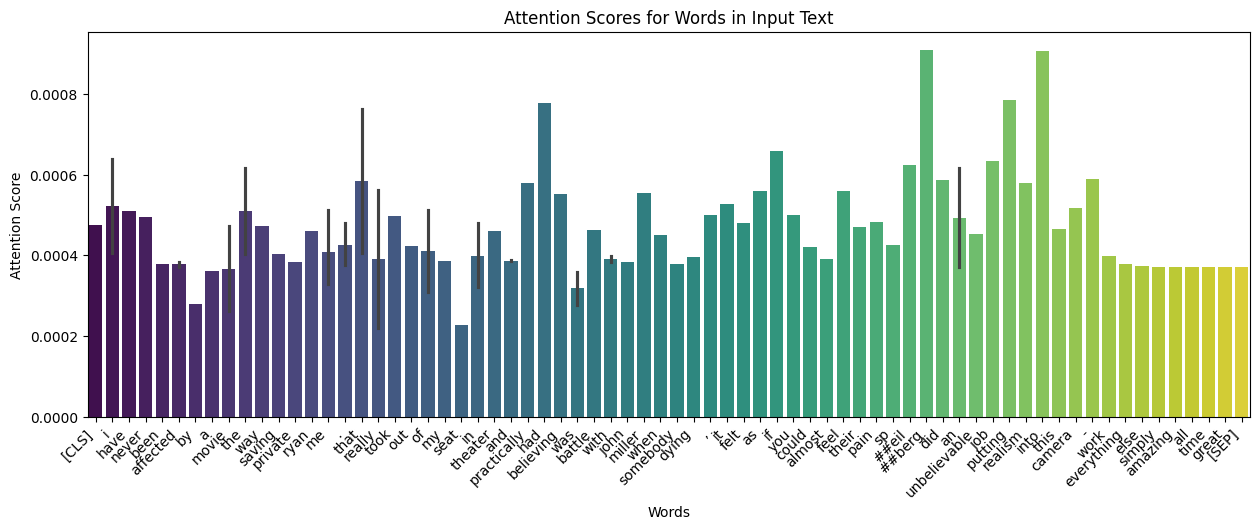

In [ ]:
# use matplotlib or seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# updated Attention Plot Function
def plot_attention(instance, attention_scores, tokenizer, max_seq_length):
    # tokenize instance using the same tokenizer as the model
    encoding = tokenizer.encode_plus(
        instance,
        add_special_tokens=True,
        max_length=max_seq_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].squeeze(0).cpu().numpy()

    # decode input_ids back to words
    words = tokenizer.convert_ids_to_tokens(input_ids)

    # remove PAD tokens and corresponding attention scores
    words = [word for word, score in zip(words, attention_scores) if word != '[PAD]']
    attention_scores = [score for word, score in zip(words, attention_scores) if word != '[PAD]']

    # plot the Attention Scores
    plt.figure(figsize=(15, 5))
    sns.barplot(x=words, y=attention_scores, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Attention Score')
    plt.title('Attention Scores for Words in Input Text')
    plt.show()

from transformers import BertTokenizer

# initialize Tokenizer (same as used during training)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# plot Attention Scores using the updated function
plot_attention(instance, attention_scores, tokenizer, max_seq_length)




## Re Implement attention mechanism with GRU. Reimplement visualizations

In [ ]:
class SentimentAnalysisModelGRU(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
        super(SentimentAnalysisModelGRU, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True)

        # attention Mechanism
        self.attention = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)

        # fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)

        # attention Mechanism
        attention_scores = self.attention(gru_out)
        attention_scores = attention_scores.squeeze(2)
        attention_weights = self.softmax(attention_scores)
        context_vector = torch.sum(attention_weights.unsqueeze(2) * gru_out, dim=1)

        output = self.fc(context_vector)
        return attention_weights, self.sigmoid(output)


In [ ]:
# re-Initialize Model and Optimizer
embedding_size = 200
hidden_size = 64
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 25
error_fn = nn.BCELoss()

model_gru = SentimentAnalysisModelGRU(input_size, embedding_size, hidden_size, num_layers, output_size)
optimizer_gru = optim.Adam(model_gru.parameters(), lr=learning_rate)

# move Model to Device
model_gru.to(device)

# train GRU Model
train_model(model_gru, train_loader, input_size, optimizer_gru, error_fn, num_epochs)

# save GRU Model
torch.save(model_gru.state_dict(), 'sentiment_analysis_GRU.pth')

SentimentAnalysisModelGRU(
  (embedding): Embedding(50922, 200)
  (gru): GRU(200, 64, batch_first=True)
  (attention): Linear(in_features=64, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Epoch 1/50, Loss: 17.2213
Epoch 2/50, Loss: 16.8563
Epoch 3/50, Loss: 16.5066
Epoch 4/50, Loss: 15.5755
Epoch 5/50, Loss: 11.4772
Epoch 6/50, Loss: 7.6255
Epoch 7/50, Loss: 4.9199
Epoch 8/50, Loss: 2.9135
Epoch 9/50, Loss: 1.9995
Epoch 10/50, Loss: 0.9464
Epoch 11/50, Loss: 0.4760
Epoch 12/50, Loss: 0.9113
Epoch 13/50, Loss: 2.0101
Epoch 14/50, Loss: 0.6952
Epoch 15/50, Loss: 0.2763
Epoch 16/50, Loss: 0.1240
Epoch 17/50, Loss: 0.0763
Epoch 18/50, Loss: 0.0596
Epoch 19/50, Loss: 0.0449
Epoch 20/50, Loss: 0.0716
Epoch 21/50, Loss: 0.3194
Epoch 22/50, Loss: 0.1095
Epoch 23/50, Loss: 0.0486
Epoch 24/50, Loss: 0.0334
Epoch 25/50, Loss: 0.0254
Epoch 26/50, Loss: 0.0208
Epoch 27/50, Loss: 0.0179
Epoch 28/50, Loss: 0.0158
Epoch 29/50, Loss: 0.0145
Epoch 30/50, Loss: 0.0132
Epoch 31/50, Loss: 0.0120
Epoch 32/50, Loss: 0.0110
Epoch 33/50, Loss: 0.0100
Epoch 34/50, Loss: 0.0091
Epoch 35/50, Loss: 0.0083
Epoch 36/50, Loss: 0.0077
Epoch 37/50, Loss: 0.0072
Epoch 38/50, Loss: 0.0067
Epoch 39/50, Los

In [ ]:
# evaluation of GRU Model
best_gru_model = SentimentAnalysisModelGRU(input_size, embedding_size, hidden_size, num_layers, output_size)
best_gru_model.load_state_dict(torch.load('sentiment_analysis_GRU.pth'))
best_gru_model.to(device)
best_gru_model.eval()

y_pred_gru = []
y_true_gru = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        attn_scores, outputs = best_gru_model(inputs)
        y_pred_gru.extend(outputs.detach().cpu().numpy())
        y_true_gru.extend(labels.detach().cpu().numpy())

y_pred_gru = [1 if pred > 0.5 else 0 for pred in y_pred_gru]
accuracy_gru = accuracy_score(y_true_gru, y_pred_gru)
print(f"GRU Model Test Accuracy: {accuracy_gru * 100:.2f}%")

<ipython-input-16-c26721fed44b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_gru_model.load_state_dict(torch.load('sentiment_analysis_GRU.pth'))


<All keys matched successfully>

SentimentAnalysisModelGRU(
  (embedding): Embedding(50922, 200)
  (gru): GRU(200, 64, batch_first=True)
  (attention): Linear(in_features=64, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

SentimentAnalysisModelGRU(
  (embedding): Embedding(50922, 200)
  (gru): GRU(200, 64, batch_first=True)
  (attention): Linear(in_features=64, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

GRU Model Test Accuracy: 76.25%


<ipython-input-17-ba14ea1ef697>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=attention_scores, palette="magma")


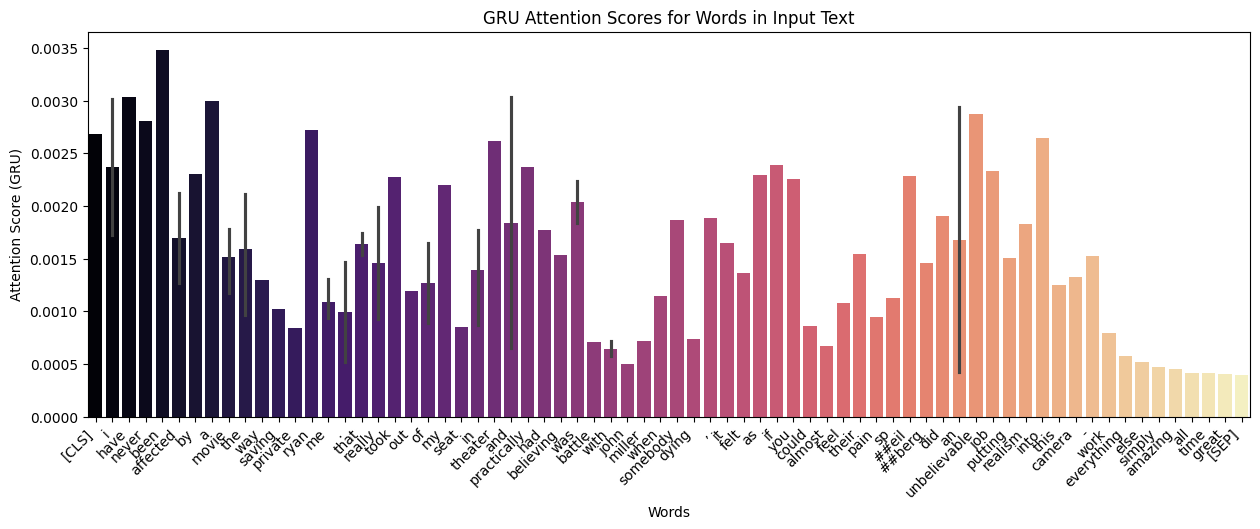

In [ ]:
# updated Attention Plot for GRU
def plot_attention_gru(instance, attention_scores, tokenizer, max_seq_length):
    # tokenize instance using the same tokenizer as the model
    encoding = tokenizer.encode_plus(
        instance,
        add_special_tokens=True,
        max_length=max_seq_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].squeeze(0).cpu().numpy()

    # decode input_ids back to words
    words = tokenizer.convert_ids_to_tokens(input_ids)

    # remove PAD tokens and corresponding attention scores
    words = [word for word, score in zip(words, attention_scores) if word != '[PAD]']
    attention_scores = [score for word, score in zip(words, attention_scores) if word != '[PAD]']

    # plot the Attention Scores
    plt.figure(figsize=(15, 5))
    sns.barplot(x=words, y=attention_scores, palette="magma")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Attention Score (GRU)')
    plt.title('GRU Attention Scores for Words in Input Text')
    plt.show()

# get Attention Scores for the Instance
attention_scores_gru, output_gru = best_gru_model(X_text_instance)
attention_scores_gru = attention_scores_gru.squeeze(0).detach().cpu().numpy()

# plot Attention Scores
plot_attention_gru(instance, attention_scores_gru, tokenizer, max_seq_length)



## **Comparison of LSTM vs. GRU:**
- LSTM achieved **68.50%** accuracy, while GRU outperformed it with **76.25%** accuracy.
- GRU trained **faster** and used parameters more efficiently compared to LSTM.
- LSTM is still useful for longer sequences or tasks requiring complex memory gates.


## **Key Takeaways:**
- **Attention Mechanism** improved interpretability by highlighting influential words.
- **GRU** was more effective for this task, showing better accuracy and faster convergence.
- **Visualizations** using bar plots and heatmaps helped explain model predictions.


## **Recommendations:**
- Experiment with **Bidirectional GRU/LSTM** for better context understanding.
- Use **Pre-trained Embeddings** like BERT or GloVe for richer semantic features.
- Improve visualizations with **interactive plots** for deeper insights.
- Apply **Dropout** in attention layers to avoid overfitting.
- Implement **Early Stopping** to enhance model generalization.

